In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import time

#stock network import
import torchvision.models as models

from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader

/school/GPTEngineer_conda/Miniconda3/envs/CNN/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/school/GPTEngineer_conda/Miniconda3/envs/CNN/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
class my_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(my_CNN, self).__init__()
        
        # Convolutional Blocks
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.3)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.5)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.batch_norm5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.batch_norm6 = nn.BatchNorm2d(128)
        self.maxpool3 = nn.MaxPool2d(2)
        self.dropout3 = nn.Dropout(0.5)

        # Fully Connected Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.batch_norm_fc = nn.BatchNorm1d(128)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Convolutional Blocks
        x = F.relu(self.batch_norm1(self.conv1(x)))
        x = F.relu(self.batch_norm2(self.conv2(x)))
        x = self.maxpool1(x)
        x = self.dropout1(x)

        x = F.relu(self.batch_norm3(self.conv3(x)))
        x = F.relu(self.batch_norm4(self.conv4(x)))
        x = self.maxpool2(x)
        x = self.dropout2(x)

        x = F.relu(self.batch_norm5(self.conv5(x)))
        x = F.relu(self.batch_norm6(self.conv6(x)))
        x = self.maxpool3(x)
        x = self.dropout3(x)

        # Fully Connected Layers
        x = self.flatten(x)
        x = F.relu(self.batch_norm_fc(self.fc1(x)))
        x = self.dropout_fc(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

model = my_CNN()

In [3]:
#Setting GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load trained model
model.load_state_dict(torch.load('/school/intelligence_coursework/new_CNN/trained_network/new_CNN_notebook.pth'))

#Using GPU
model = model.to(device)
print("Model device:", next(model.parameters()).device)

Model device: cuda:0


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=4)

classes = trainset.classes
criterion = nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified


In [8]:
#freeze network
for param in model.parameters():
    param.requires_grad = False

    #unfreeze fuly connected layer
for param in model.fc2.parameters():
    param.requires_grad = True

#randomize the wights
model.fc2.reset_parameters()

#apply optimizer for the last layer
#fine_optimizer = torch.optim.Adam(model.fc.parameters(), lr = 0.0003, weight_decay = 0.00001)
#fine_optimizer = optim.SGD(model.parameters(), lr = 0.0015, momentum = 0.9)
fine_optimizer = optim.Adagrad(model.fc2.parameters(), lr = 0.041702200470257404, weight_decay = 0.0007203244934421581)
#fine_optimizer = optim.AdamW(model.parameters(), lr = 0.015, weight_decay = 0.0001)

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(fine_optimizer, T_max=10)
scheduler = torch.optim.lr_scheduler.ExponentialLR(fine_optimizer, gamma=0.95)

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Initialize early stopping
early_stopping = EarlyStopping(patience=7)

val_loader = DataLoader(testset, batch_size=512, shuffle=True)
            
# List to store average loss per epoch
epoch_losses = []

#time tracking
start_time = time.time()

fine_tune_epochs = 5
for epoch in range(fine_tune_epochs):
    model.train()
    running_loss = 0.0
    num_batches = 0
    for i, data in enumerate(trainloader, 0):
        try:
            inputs, labels = data[0].to(device), data[1].to(device)
            fine_optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            fine_optimizer.step()
            running_loss += loss.item()
            num_batches += 1
        except Exception as e:
            print(f"Error in Epoch {epoch}, Batch {i}: {e}")
            break
    average_loss = running_loss / num_batches
    epoch_losses.append(average_loss)
    print(f'Epoch {epoch + 1}, Average Loss: {average_loss:0.4f}')
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}')

    # Early Stopping check
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

    scheduler.step()
    
end_time = time.time()  # End time for the epoch
epoch_duration = end_time - start_time  # Calculate the duration of the epoch
print(f'Epoch {epoch + 1} completed in {epoch_duration:.2f} seconds')

Epoch 1, Average Loss: 0.5827
Epoch 1, Validation Loss: 0.4762
Epoch 2, Average Loss: 0.5065
Epoch 2, Validation Loss: 0.4684
Epoch 3, Average Loss: 0.4993
Epoch 3, Validation Loss: 0.4736
Epoch 4, Average Loss: 0.4946
Epoch 4, Validation Loss: 0.4720
Epoch 5, Average Loss: 0.4882
Epoch 5, Validation Loss: 0.4740
Epoch 5 completed in 18.70 seconds


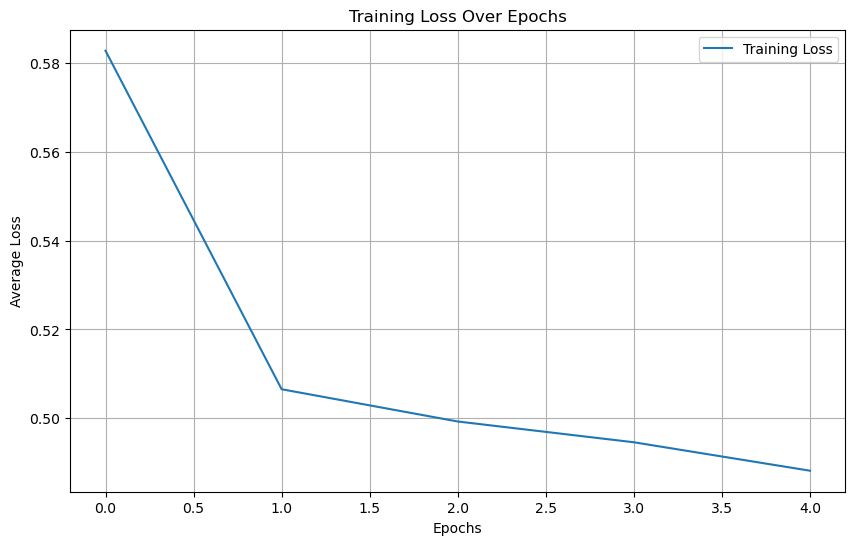

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
model.eval()
correct = 0
total = 0
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label.item()]] += 1
            total_pred[classes[label.item()]] += 1
            
print('Accuracy of the network on the 10 000 test images: %f %%' % (100 * correct / total))

for classname, correct_count in correct_pred.items():
    accuracy = 100* float(correct_count)/ total_pred[classname]
    print(f'Accuracy for: {classname:5s} is {accuracy:0.1f} %')

Accuracy of the network on the 10 000 test images: 84.120000 %
Accuracy for: airplane is 83.5 %
Accuracy for: automobile is 92.5 %
Accuracy for: bird  is 74.6 %
Accuracy for: cat   is 65.0 %
Accuracy for: deer  is 85.7 %
Accuracy for: dog   is 75.6 %
Accuracy for: frog  is 92.9 %
Accuracy for: horse is 86.4 %
Accuracy for: ship  is 93.0 %
Accuracy for: truck is 92.0 %


Precision: 0.8411
Recall: 0.8410
F1 Score: 0.8394


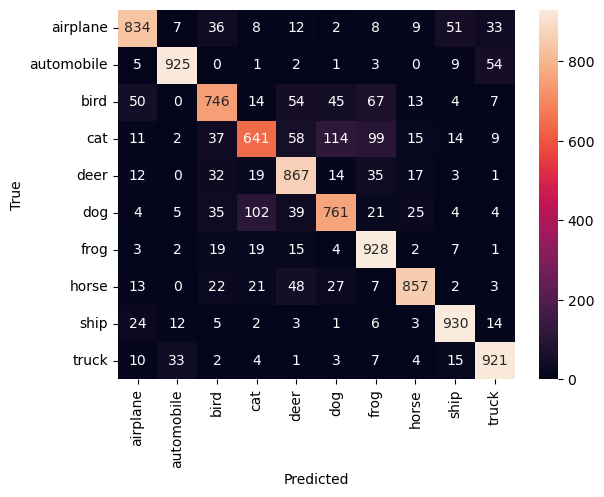

In [20]:
all_labels = []
all_predictions = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predicted.cpu().numpy())

# Concatenate all batches
all_labels = np.concatenate(all_labels)
all_predictions = np.concatenate(all_predictions)

#Assigning classes
def indices_to_class_names(indices, class_names):
    return [class_names[i] for i in indices]

# Apply the mapping to all labels and predictions
all_labels_names = indices_to_class_names(all_labels, classes)
all_predictions_names = indices_to_class_names(all_predictions, classes)

# Calculate metrics using the numerical indices
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
f1 = f1_score(all_labels, all_predictions, average='macro')

# Print metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Confusion Matrix with Class Names
conf_matrix = confusion_matrix(all_labels_names, all_predictions_names)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()